<a href="https://colab.research.google.com/github/Shrutiba/iisc_cds/blob/main/M2_MP4_NB_Employee_Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

## **Note:** This notebook is part of an in-house Kaggle competition

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1c7PrbKrURFcnEB61dSoS9cBnUUVhhj-l/view?usp=drive_link) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.

## Grading = 10 Points

In [86]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Install CatBoost

In [87]:
!pip -qq install catboost

In [88]:
!pip install dask[dataframe]

### Import Required Packages

In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics,Pool,cv
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [300]:
# read the dataset
# YOUR CODE HERE
edata = pd.read_csv('hr_employee_attrition_train.csv')

#Encode Target Variable
edata['attrition'] = edata['attrition'].astype('category')
edata['attrition'] = edata['attrition'].map({'Yes': 1, 'No': 0})


In [91]:
# Check the shape of dataframe.
# YOUR CODE HERE
edata.shape

(1170, 35)

There can be more than one file to read as this is introduced as a competition, dataset has one file for training the model. Their can be other files as one containing the test features and the other can be the true labels.

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

**Hint:** Use `for` to iterate through each column.

In [92]:
edata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   age                       1170 non-null   int64 
 1   businesstravel            1170 non-null   object
 2   dailyrate                 1170 non-null   int64 
 3   department                1170 non-null   object
 4   distancefromhome          1170 non-null   int64 
 5   education                 1170 non-null   int64 
 6   educationfield            1170 non-null   object
 7   employeecount             1170 non-null   int64 
 8   employeenumber            1170 non-null   int64 
 9   environmentsatisfaction   1170 non-null   int64 
 10  gender                    1170 non-null   object
 11  hourlyrate                1170 non-null   int64 
 12  jobinvolvement            1170 non-null   int64 
 13  joblevel                  1170 non-null   int64 
 14  jobrole                 

In [93]:
edata.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,45,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,2,Female,93,2,2,Manufacturing Director,4,Married,5906,23888,0,Y,No,13,3,4,80,2,10,2,2,9,8,3,8,No
1,34,Travel_Rarely,970,Research & Development,8,2,Medical,1,757,2,Female,96,3,2,Healthcare Representative,3,Single,6142,7360,3,Y,No,11,3,4,80,0,10,2,3,5,1,4,3,No


In [301]:
# YOUR CODE HERE
ecategorical_col = ['businesstravel','department','educationfield','gender','jobrole','maritalstatus','over18','overtime']
ordered_cat_col = ['education','environmentsatisfaction','jobinvolvement','joblevel','jobsatisfaction','performancerating','relationshipsatisfaction','stockoptionlevel','worklifebalance']
enumerical_col = ['age','dailyrate','distancefromhome','employeecount','employeenumber','hourlyrate','monthlyincome','monthlyrate','numcompaniesworked','percentsalaryhike','standardhours','totalworkingyears','trainingtimeslastyear','yearsatcompany','yearsincurrentrole','yearssincelastpromotion','yearswithcurrmanager']
target = ['attrition']

In [152]:
for col in ecategorical_col:
    unique_values = edata[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'businesstravel': ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Unique values in 'department': ['Research & Development' 'Sales' 'Human Resources']
Unique values in 'educationfield': ['Life Sciences' 'Medical' 'Technical Degree' 'Other' 'Marketing'
 'Human Resources']
Unique values in 'gender': ['Female' 'Male']
Unique values in 'jobrole': ['Manufacturing Director' 'Healthcare Representative' 'Research Scientist'
 'Sales Executive' 'Laboratory Technician' 'Sales Representative'
 'Human Resources' 'Manager' 'Research Director']
Unique values in 'maritalstatus': ['Married' 'Single' 'Divorced']
Unique values in 'over18': ['Y']
Unique values in 'overtime': ['No' 'Yes']


In [253]:
# Label Encoding
for col in ecategorical_col:
    edata[col] = edata[col].astype('category')
    edata[col] = edata[col].cat.codes

In [252]:
edata.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,45,2,556,1,25,2,1,1,1888,2,0,93,2,2,4,4,1,5906,23888,0,0,0,13,3,4,80,2,10,2,2,9,8,3,8,0
1,34,2,970,1,8,2,3,1,757,2,0,96,3,2,0,3,2,6142,7360,3,0,0,11,3,4,80,0,10,2,3,5,1,4,3,0


In [247]:
for col in ecategorical_col:
    unique_values = edata[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'businesstravel': [2 1 0]
Unique values in 'department': [1 2 0]
Unique values in 'educationfield': [1 3 5 4 2 0]
Unique values in 'gender': [0 1]
Unique values in 'jobrole': [4 0 6 7 2 8 1 3 5]
Unique values in 'maritalstatus': [1 2 0]
Unique values in 'over18': [0]
Unique values in 'overtime': [0 1]


In [95]:
edata[ecategorical_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   businesstravel  1170 non-null   object
 1   department      1170 non-null   object
 2   educationfield  1170 non-null   object
 3   gender          1170 non-null   object
 4   jobrole         1170 non-null   object
 5   maritalstatus   1170 non-null   object
 6   over18          1170 non-null   object
 7   overtime        1170 non-null   object
dtypes: object(8)
memory usage: 73.3+ KB


In [ ]:
edata[enumerical_col].info()

In [ ]:
edata.isna().sum()

In [ ]:
for col in enumerical_col:
    print(f'{col}:{len(edata[col].unique())}')

First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

In [302]:
max_values = edata[enumerical_col].max()
min_values = edata[enumerical_col].min()

zipped_values = list(zip(min_values, max_values))
zipped_values[0][0]

18

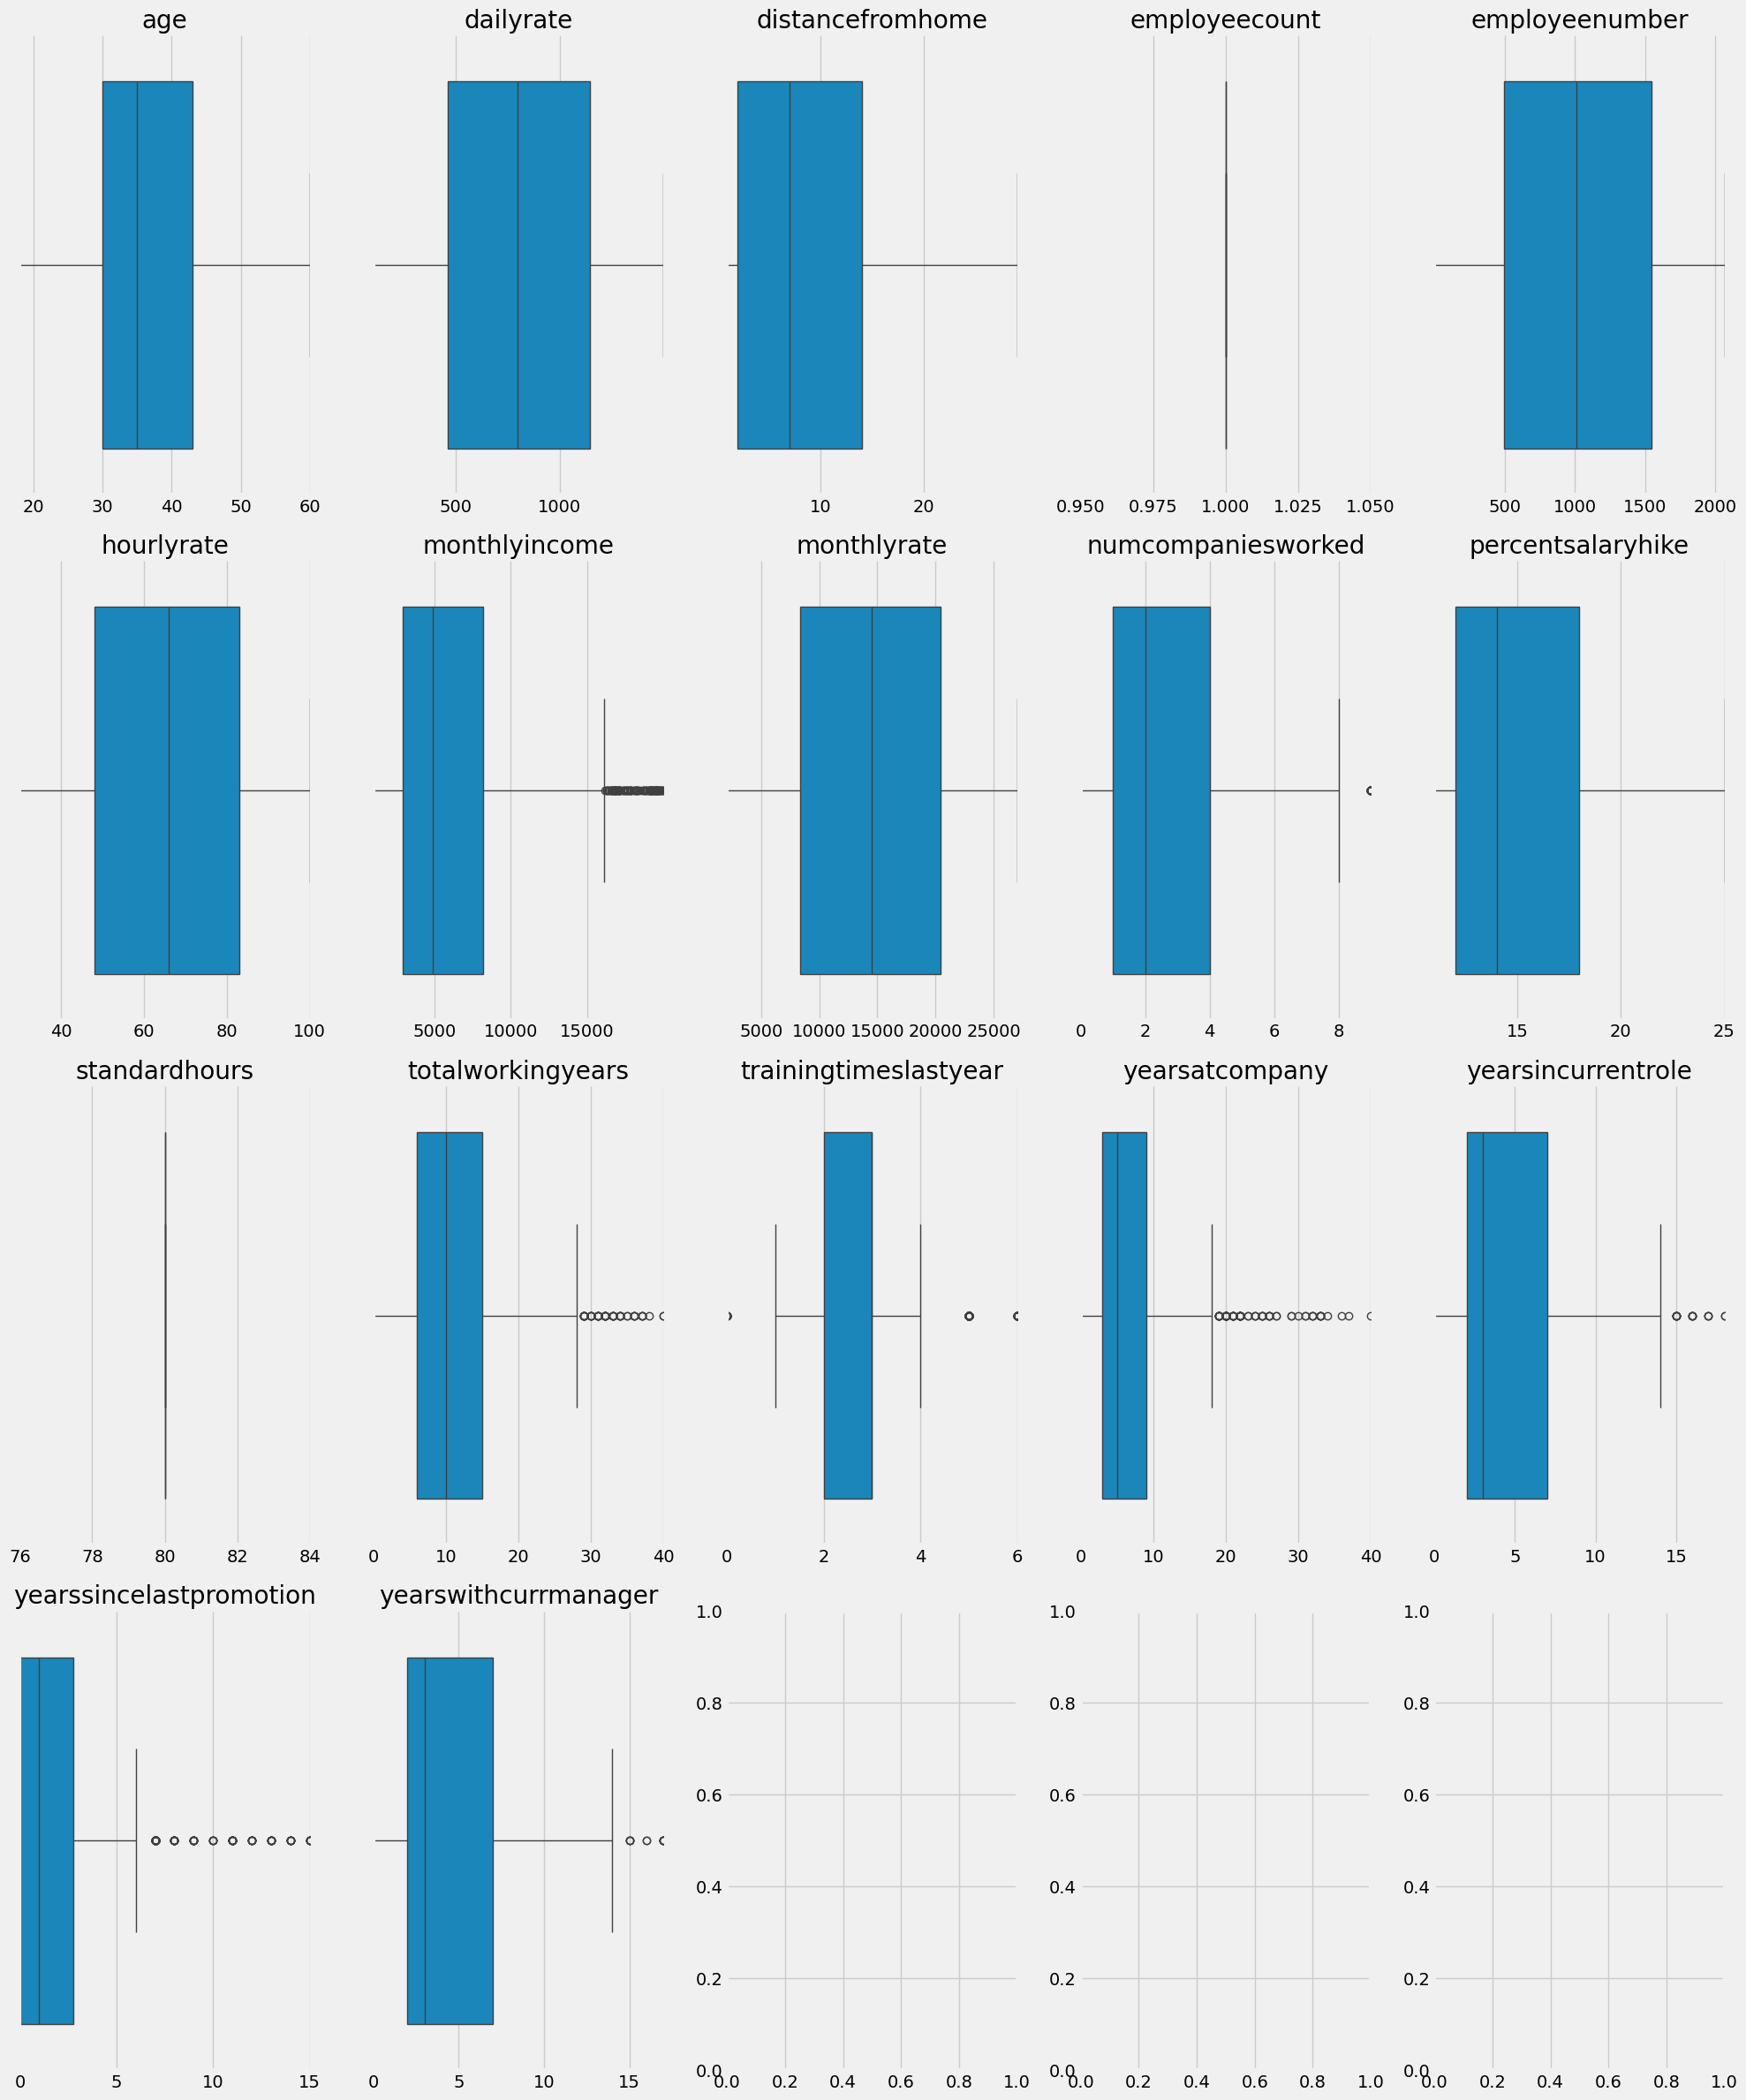

In [304]:

# Calculate the number of rows and columns for the subplot grid
num_cols = 5  # Number of columns in the grid
num_rows = 4  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(enumerical_col):
    sns.boxplot(x=edata[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_xlim(zipped_values[i][0],zipped_values[i][1])


# Remove spines for cleaner look
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### Handling outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [305]:
quantiles = edata[enumerical_col].quantile([0.25, 0.75])
quantiles

,age,dailyrate,distancefromhome,employeecount,employeenumber,hourlyrate,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,standardhours,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0.25,30.0,461.00,2.0,1.0,496.25,48.0,2914.75,8387.50,1.0,12.0,80.0,6.0,2.0,3.0,2.0,0.00,2.0
0.75,43.0,1146.75,14.0,1.0,1548.50,83.0,8215.25,20456.25,4.0,18.0,80.0,15.0,3.0,9.0,7.0,2.75,7.0


In [306]:
# YOUR CODE HERE
quantiles = edata[enumerical_col].quantile([0.25, 0.75])

for col in enumerical_col:
    lower_bound = quantiles[col][0.25]
    upper_bound = quantiles[col][0.75]

    edata.loc[edata[col] < lower_bound, col] = lower_bound
    edata.loc[edata[col] > upper_bound, col] = upper_bound

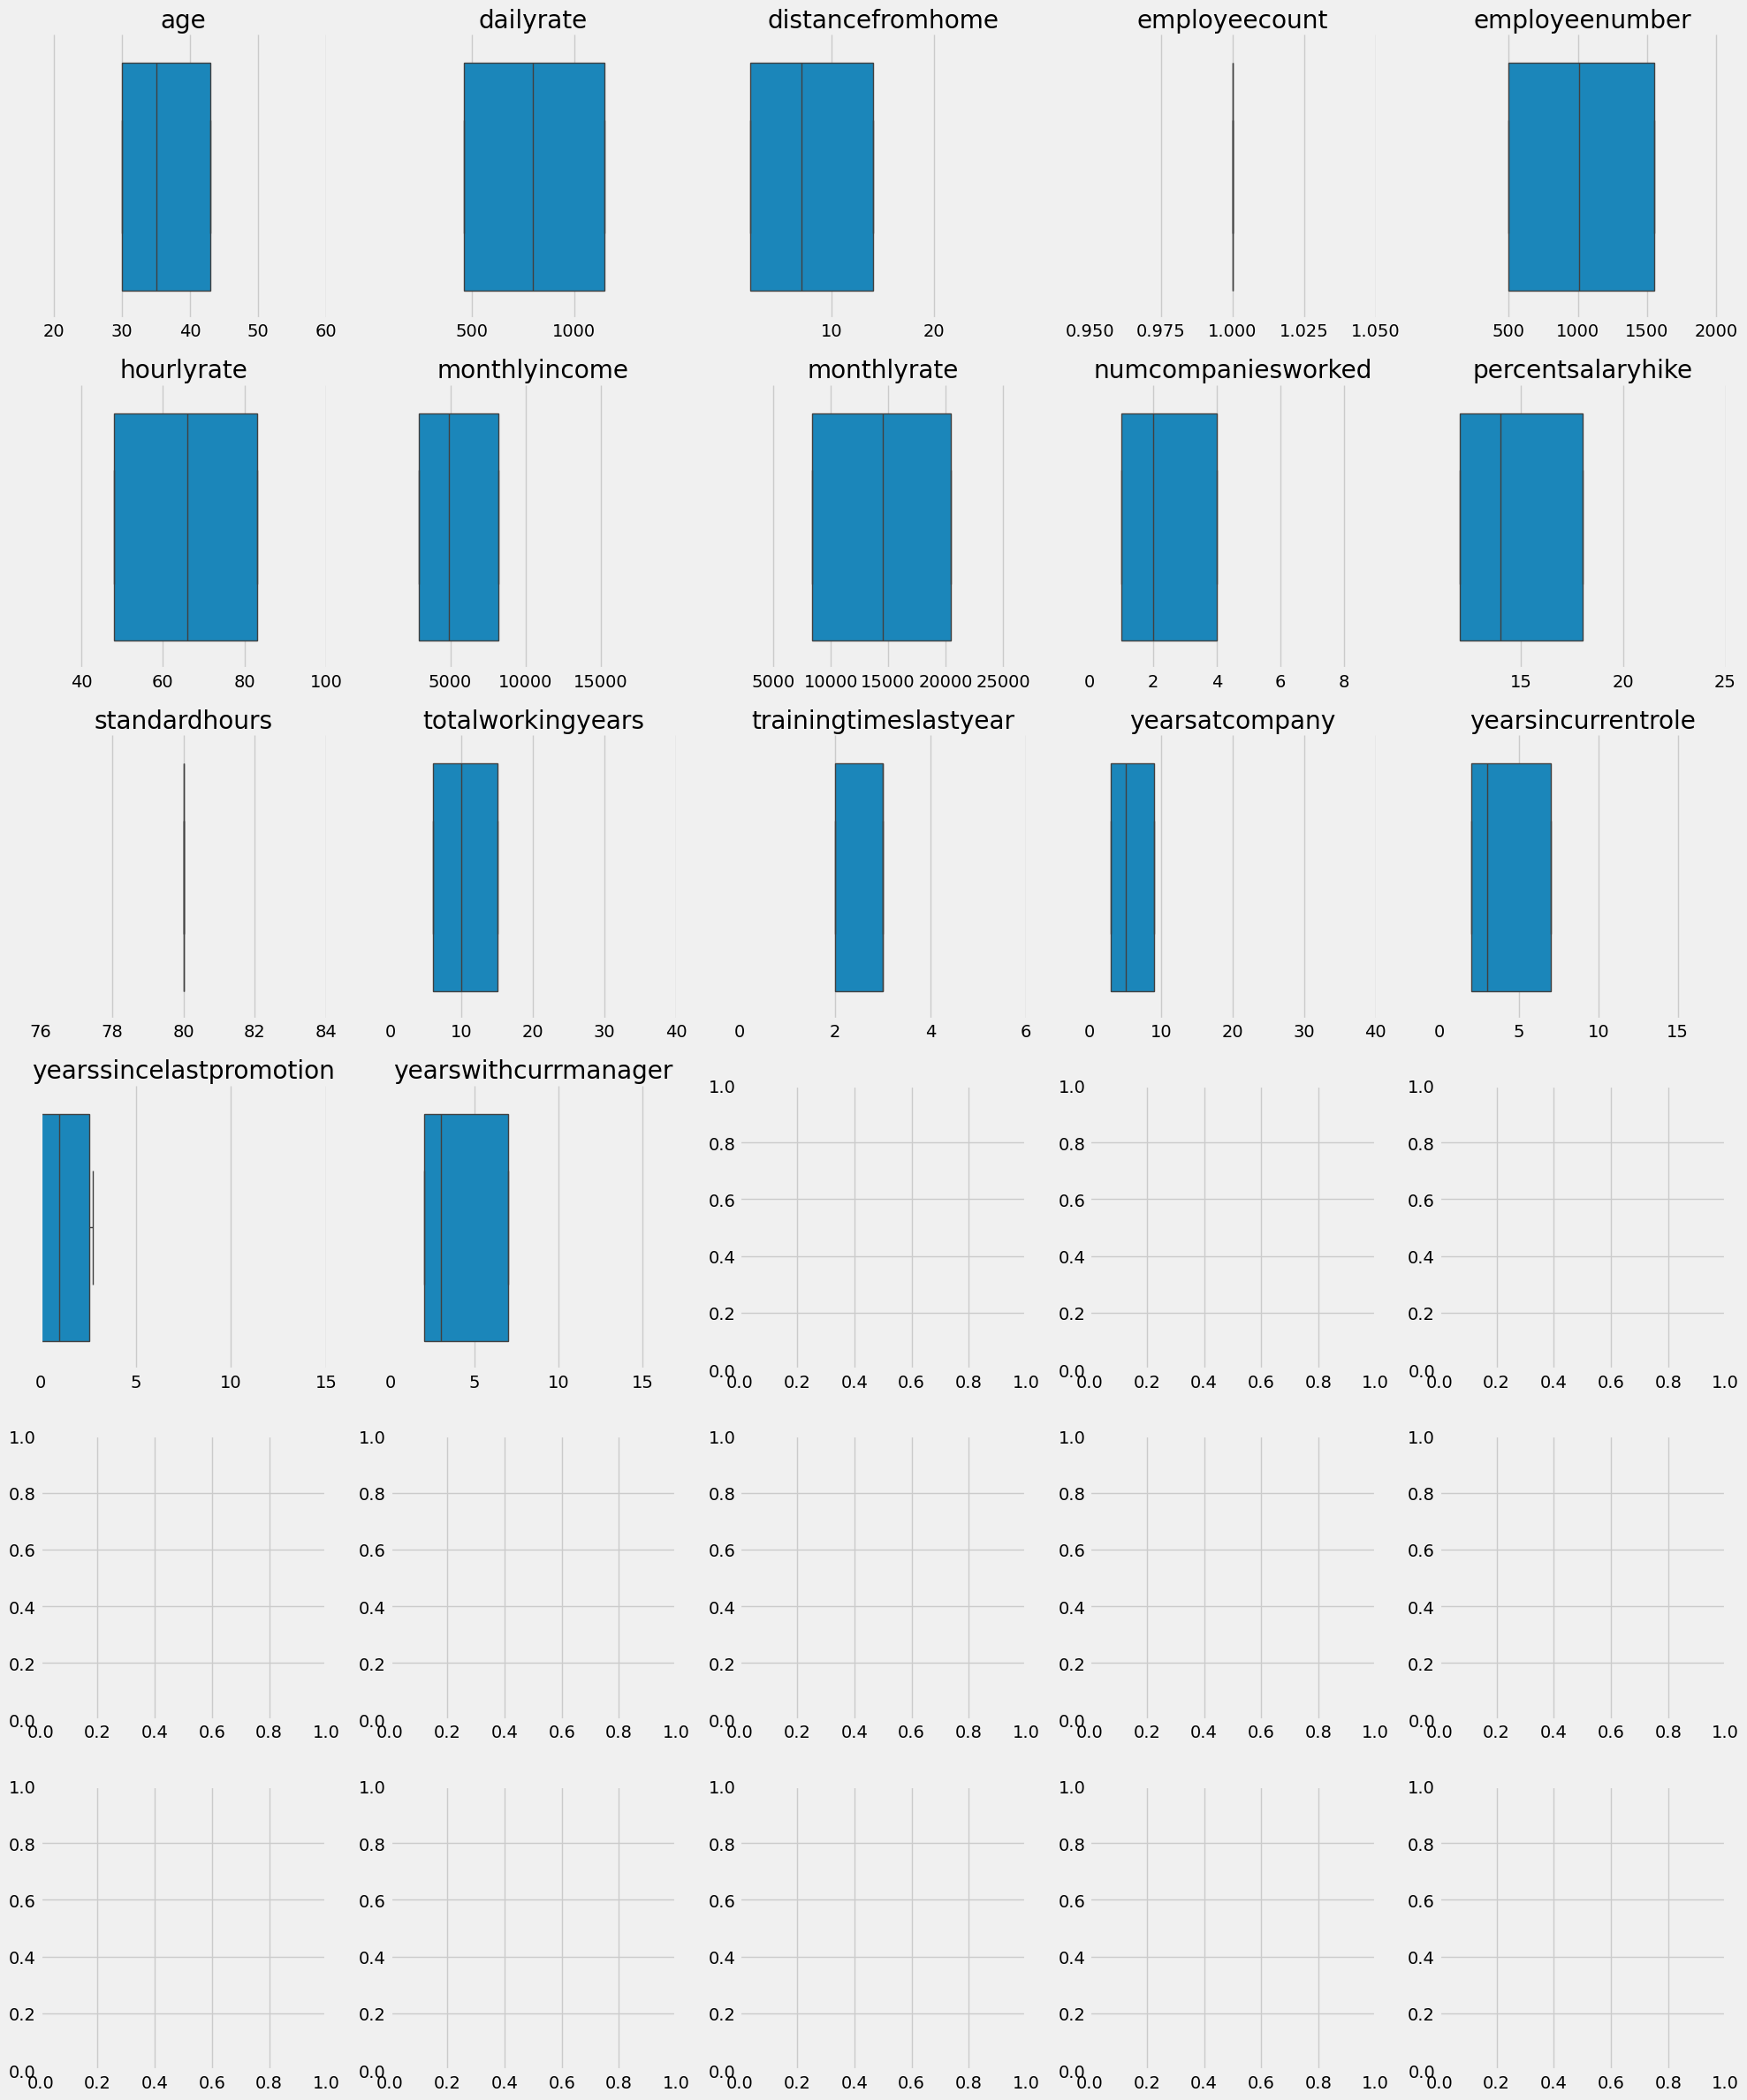

In [307]:
# Recheck for outliers
# YOUR CODE HERE
# Calculate the number of rows and columns for the subplot grid
num_cols = 5  # Number of columns in the grid
num_rows = 6  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(enumerical_col):
    sns.boxplot(x=edata[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_xlim(zipped_values[i][0],zipped_values[i][1])


# Remove spines for cleaner look
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Feature Selection

In [308]:
# Conducting Feature Selection by various Filter Methods
#1. Correlation Method
f1_correlation = edata[enumerical_col + ['attrition']].corr()['attrition'].abs().sort_values(ascending=False)
print(f1_correlation)

attrition                  1.000000
yearsatcompany             0.177676
totalworkingyears          0.177190
age                        0.165979
monthlyincome              0.161451
yearsincurrentrole         0.160449
yearswithcurrmanager       0.130218
distancefromhome           0.098860
dailyrate                  0.064893
yearssincelastpromotion    0.059147
trainingtimeslastyear      0.039014
hourlyrate                 0.027401
monthlyrate                0.018437
employeenumber             0.011154
numcompaniesworked         0.006518
percentsalaryhike          0.002708
employeecount                   NaN
standardhours                   NaN
Name: attrition, dtype: float64


In [309]:
# 1. Separate features (X) and target (y)
X = edata[enumerical_col]
y = edata['attrition']

# 2. Perform ANOVA feature selection
f_statistic, p_values = f_classif(X, y)

# 3. Create a DataFrame to store results
f2_anova = pd.DataFrame({'Feature': enumerical_col, 'F-statistic': f_statistic, 'p-value': p_values})
f2_anova = f2_anova.sort_values(by='F-statistic', ascending=False)

print(f2_anova)

                    Feature  F-statistic       p-value
13           yearsatcompany    38.074278  9.374435e-10
11        totalworkingyears    37.859699  1.042809e-09
0                       age    33.088880  1.123490e-08
6             monthlyincome    31.260495  2.807358e-08
14       yearsincurrentrole    30.863359  3.426495e-08
16     yearswithcurrmanager    20.146931  7.880643e-06
2          distancefromhome    11.527904  7.086273e-04
1                 dailyrate     4.939437  2.644151e-02
15  yearssincelastpromotion     4.100490  4.309791e-02
12    trainingtimeslastyear     1.780551  1.823417e-01
5                hourlyrate     0.877616  3.490492e-01
7               monthlyrate     0.397181  5.286722e-01
4            employeenumber     0.145328  7.031103e-01
8        numcompaniesworked     0.049621  8.237623e-01
9         percentsalaryhike     0.008565  9.262784e-01
3             employeecount          NaN           NaN
10            standardhours          NaN           NaN


In [310]:
# Drop this col as it has same value across all the data points
edata.drop(columns=['performancerating','employeecount','standardhours'],inplace=True)

In [312]:
# Remove column dropped columns
ecategorical_col = ['businesstravel','department','educationfield','gender','jobrole','maritalstatus','over18','overtime']
ordered_cat_col = ['education','environmentsatisfaction','jobinvolvement','joblevel','jobsatisfaction','relationshipsatisfaction','stockoptionlevel','worklifebalance']
enumerical_col = ['age','dailyrate','distancefromhome','employeenumber','hourlyrate','monthlyincome','monthlyrate','numcompaniesworked','percentsalaryhike','totalworkingyears','trainingtimeslastyear','yearsatcompany','yearsincurrentrole','yearssincelastpromotion','yearswithcurrmanager']

### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

**Hint:** Use value_counts()

In [313]:
# Count of unique values in Attrition column
# YOUR CODE HERE
attrition_counts = edata['attrition'].value_counts()

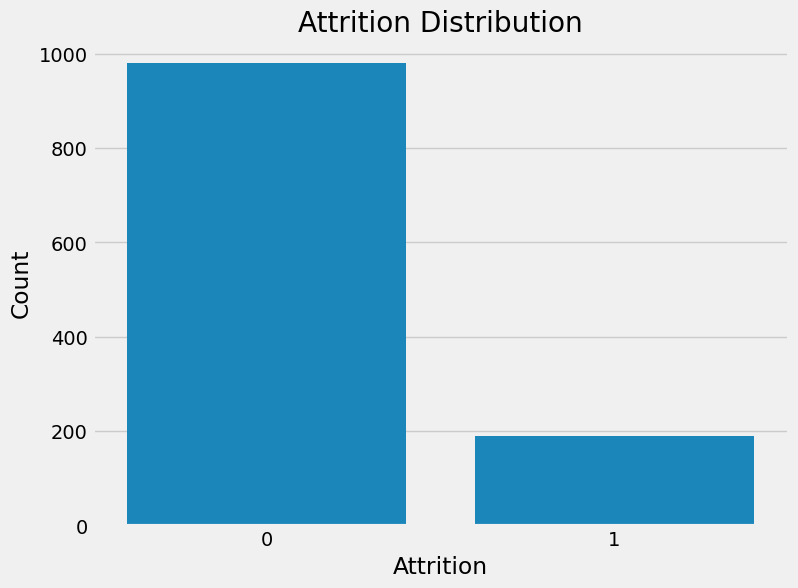

In [314]:
# Plot barplot to visualize balance/imbalance
# YOUR CODE HERE
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.barplot(x=attrition_counts.index, y=attrition_counts.values)
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()

If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE
2. Cross Validation
3. Regularizing the model's parameters

###Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

**Hint:** Use sns.pairplot

In [155]:
from sklearn.feature_selection import f_classif, SelectKBest


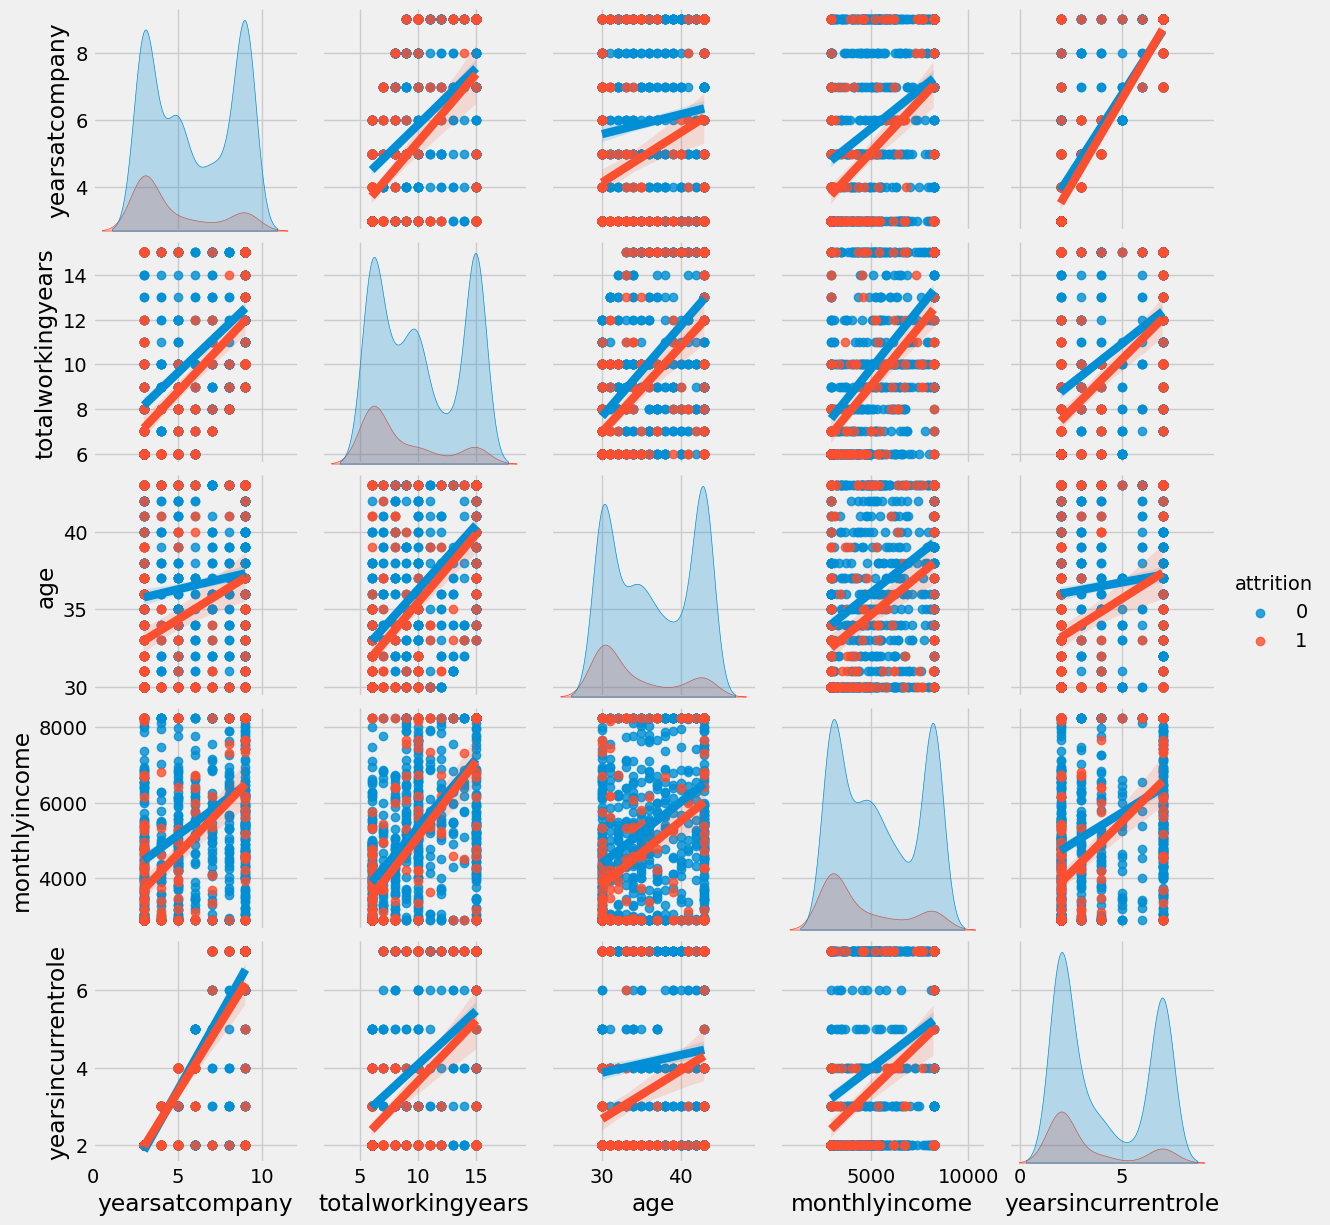

In [315]:
# Visualize a pairplot with relevant features
# YOUR CODE HERE
selected_columns = f1_correlation.index[:6]

# Create pair plot with 'Attrition' as hue
sns.pairplot(edata[selected_columns], hue='attrition',kind='reg')
plt.show()

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

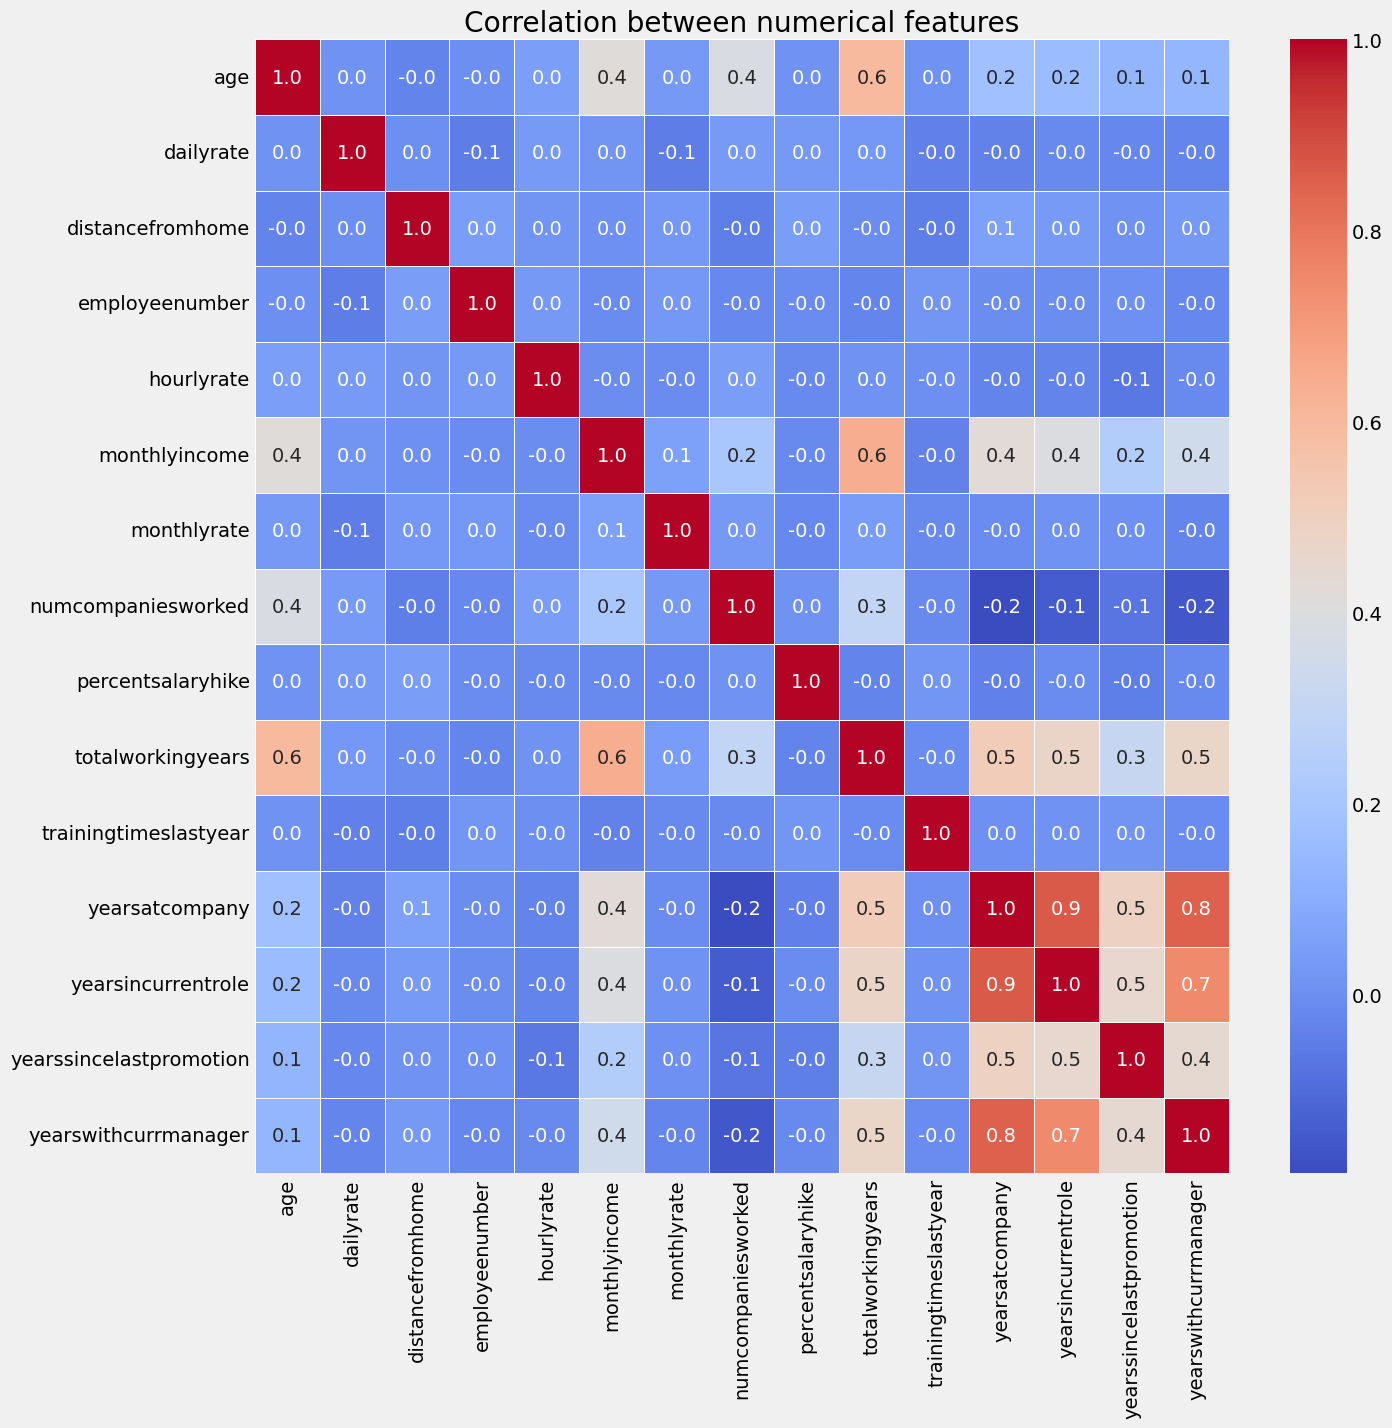

In [316]:
# Visualize heatmap
# YOUR CODE HERE
correlation_matrix = edata[enumerical_col].corr()

plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".1f",linewidths=0.5)
plt.title('Correlation between numerical features')
plt.show()

In [317]:
# Further drop years at company as it is highly correlated with many other columns
edata.drop(columns=['yearsatcompany','employeenumber'],inplace=True)

In [318]:
# Remove column dropped columns
ecategorical_col = ['businesstravel','department','educationfield','gender','jobrole','maritalstatus','over18','overtime']
ordered_cat_col = ['education','environmentsatisfaction','jobinvolvement','joblevel','jobsatisfaction','relationshipsatisfaction','stockoptionlevel','worklifebalance']
enumerical_col = ['age','dailyrate','distancefromhome','hourlyrate','monthlyincome','monthlyrate','numcompaniesworked','percentsalaryhike','totalworkingyears','trainingtimeslastyear','yearsincurrentrole','yearssincelastpromotion','yearswithcurrmanager']

Comment on the observations made with the pairplot and heatmap

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In [320]:
# YOUR CODE HERE
etest = pd.read_csv('hr_employee_attrition_train.csv')
etest.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,45,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,2,Female,93,2,2,Manufacturing Director,4,Married,5906,23888,0,Y,No,13,3,4,80,2,10,2,2,9,8,3,8,No
1,34,Travel_Rarely,970,Research & Development,8,2,Medical,1,757,2,Female,96,3,2,Healthcare Representative,3,Single,6142,7360,3,Y,No,11,3,4,80,0,10,2,3,5,1,4,3,No


In [269]:
for col in ecategorical_col:
    etest[col] = etest[col].astype('category')
    etest[col] = etest[col].cat.codes

In [321]:
etest.drop(['performancerating','standardhours','yearsatcompany','employeecount','employeenumber'],inplace=True,axis=1)

In [322]:
#Adjust outliers
quantiles = etest[enumerical_col].quantile([0.25, 0.75])

for col in enumerical_col:
    lower_bound = quantiles[col][0.25]
    upper_bound = quantiles[col][0.75]

    etest.loc[etest[col] < lower_bound, col] = lower_bound
    etest.loc[etest[col] > upper_bound, col] = upper_bound

In [323]:
etest.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43,Travel_Rarely,556.0,Research & Development,14,2,Life Sciences,2,Female,83,2,2,Manufacturing Director,4,Married,5906.0,20456.25,1,Y,No,13,4,2,10,2,2,7,2.75,7,No
1,34,Travel_Rarely,970.0,Research & Development,8,2,Medical,2,Female,83,3,2,Healthcare Representative,3,Single,6142.0,8387.50,3,Y,No,12,4,0,10,2,3,2,2.75,3,No


Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

Refer to the Additional Notebook: CatBoost parameter tuning [CDS-B9 GDrive -> Module 2 -> Assignments -> January 11, 2025 -> Additional Notebook (ungraded) -> Addl_NB_Tuning_hyerparameters_using_Hyperopt]

In [191]:
!pip -qq install hyperopt

In [ ]:
# Create an objective function which hyperopt needs to minimize
import hyperopt

def hyperopt_objective(params):
    # Create model
    model = CatBoostClassifier(
                               l2_leaf_reg = int(params['l2_leaf_reg']),
                               learning_rate = params['learning_rate'],
                               iterations=500,
                               eval_metric=metrics.Accuracy(),
                               random_seed=42,
                               verbose=False,
                               loss_function=metrics.Logloss()
                               )
    # Perform cross-validation
    cv_data = cv(
                 Pool(X, y, cat_features=categorical_features_indices),
                 model.get_params(),
                 logging_level='Silent'
                 )
    # Best test accuracy
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])

    return 1 - best_accuracy          # as hyperopt minimizes

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

**Hint:** Column containing the information on attrition will be the target column.

In [280]:
# Copy the data
# YOUR CODE HERE
ecatboost = edata

In [281]:
ecatboost.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43,2,556.0,1,14,2,1,2,0,83,2,2,4,4,1,5906.0,20456.25,1,0,0,13,4,1,10,2,2,7,2.75,7,0
1,34,2,970.0,1,8,2,3,2,0,83,3,2,0,3,2,6142.0,8387.50,3,0,0,12,4,0,10,2,3,2,2.75,3,0


In [282]:
# Target Column
# YOUR CODE HERE
y = ecatboost['attrition']

In [283]:
# Feature Space
# YOUR CODE HERE
X = pd.concat([ecatboost[enumerical_col], ecatboost[ecategorical_col]], axis=1).copy()

In [284]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [285]:
X_resampled.shape

(1962, 29)

In [287]:
# Get categorical features indices by selecting the features which are of type other than float
categorical_features_indices = np.where(X.dtypes != float)[0]            # np.where will give indices where the condition is True
categorical_features_indices

array([ 0,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 20,
       21, 22, 23, 24, 25, 26, 27, 28])

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [293]:
# Create training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = etest

In [289]:
# Create params dictionary
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
# Create Pool for training set
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Create Pool for validation set
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)
print(validate_pool)

In [298]:
def model_metrics(model):

# Assuming 'model_cat' is your trained CatBoost model
# Assuming 'X_validation' and 'y_validation' are your validation data

    # 1. Predictions
    y_pred = model.predict(validate_pool) # Get predicted labels
    y_pred_proba = model.predict_proba(validate_pool)[:, 1]  # Get predicted probabilities for class 1

    # 2. Calculate Metrics
    roc_auc = roc_auc_score(validate_pool.get_label(), y_pred_proba)
    accuracy = accuracy_score(validate_pool.get_label(), y_pred)
    f1 = f1_score(validate_pool.get_label(), y_pred)

    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(validate_pool.get_label(), y_pred)

    # Calculate recall
    recall = recall_score(validate_pool.get_label(), y_pred)

    # 3. Print Results
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Optional: Display Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(validate_pool.get_label(), y_pred)
    print("Confusion Matrix:")
    print(cm)

In [294]:
# Create CatBoost model
# YOUR CODE HERE
# Create CatBoost model
model_cat = CatBoostClassifier(custom_loss=[params['eval_metric']],
                           random_seed=params['random_seed'],
                           logging_level=params['logging_level'])

In [295]:
# Model training
# YOUR CODE HERE
model_cat.fit(train_pool,
          eval_set=validate_pool,
          verbose=False);

### Model performance

In [299]:
# Model performance on all sets
# YOUR CODE HERE
model_metrics(model_cat)

ROC AUC: 0.9574
Accuracy: 0.9043
F1 Score: 0.9023
Precision: 0.9394
Recall: 0.8680
Confusion Matrix:
[[227  14]
 [ 33 217]]


## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [115]:
# Copy dataframe
# YOUR CODE HERE


**Hint:** Use pd.get_dummies

In [116]:
# Handling categorical features
# YOUR CODE HERE

In [117]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

When creating the dummy variables, the name of attrition column was changed, rename to 'attrition' again.

**Hint:** Use .rename

In [118]:
# Rename target column
# YOUR CODE HERE

In [119]:
# Feature Space
# YOUR CODE HERE

# Targer label
# YOUR CODE HERE

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use XGBClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [120]:
# Create XGBoost classifier model
# YOUR CODE HERE

In [121]:
# Model training
# YOUR CODE HERE

### Model Performance

In [122]:
# Model performance on all sets
# YOUR CODE HERE

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [123]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
# YOUR CODE HERE

# Handling categorical features
# YOUR CODE HERE

# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

# Rename target column
# YOUR CODE HERE

# Features Space
# YOUR CODE HERE

# Target Label
# YOUR CODE HERE

### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [124]:
# Create LightGBM classifier model
# YOUR CODE HERE

In [125]:
# Model training
# YOUR CODE HERE

### Model performance

In [126]:
# Model performance on all sets
# YOUR CODE HERE

## Results

**Exercise 12: Create a dataframe of XGBoost results and CatBoost results and display them [0.5 Mark]**

**Hint:** Use pd.DataFrame

In [127]:
# Create a dataframe for computed metrics for different models
# YOUR CODE HERE

Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

## Kaggle Prediction

Load data from Kaggle competition site

In [128]:
# From the given Kaggle competition link, load the dataset 'hr_employee_attrition_test.csv'
# YOUR CODE HERE

In [129]:
# From the dataset 'hr_employee_attrition_test.csv', drop columns ['id','employeenumber', 'employeecount', 'over18'] having single value
# YOUR CODE HERE

In [130]:
# Handle categorical features
# YOUR CODE HERE

In [131]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

Predictions

In [132]:
# Get the predictions using your already trained CatBoost classifier model achieved in Exercise 9
# YOUR CODE HERE

In [133]:
# Get the predictions using your already trained XGBoost classifier model achieved in Exercise 11
# YOUR CODE HERE

Get the predictions using your trained Microsoft LightGBM model (Optional)

In [134]:
# Get the predictions using your already trained Microsoft LightGBM classifier model
# achieved under the optional exercise 'Apply LightGBM (Optional)'
# YOUR CODE HERE

Save predictions to csv and submit under given Kaggle competiton link

In [135]:
# YOUR CODE HERE